In [132]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.decomposition import MiniBatchDictionaryLearning
from PIL import Image
import numpy.random
import matplotlib.pyplot as plt
from numpy.linalg import inv
import math
import time
import spams

In [158]:
def fetchImageR():
    im = Image.open("clockwork-angels.jpg")
    pix = im.load()
    print (im.size)  
    
    inputR = np.zeros((im.size))
    for i in range(0, 3448):
        for j in range(0, 1713):
            inputR[i][j] = float(pix[i, j][0])
    return inputR

inputR = fetchImageR()

(3448, 1713)


In [159]:
def generateRandomX():
    return np.random.randint(0, 3432)
def generateRandomY():
    return np.random.randint(0, 1697)

def populateInput():
    X = np.zeros((1000, 16, 16))
    for i in range(0,1000):
        randX = generateRandomX()
        randY = generateRandomY()
        for x in range(0,16):
            for y in range(0, 16):
                X[i][x][y] = inputR[randX + x][randY + y]
    return X
X = populateInput()

PCA learning error per input:  2133.3082659982138


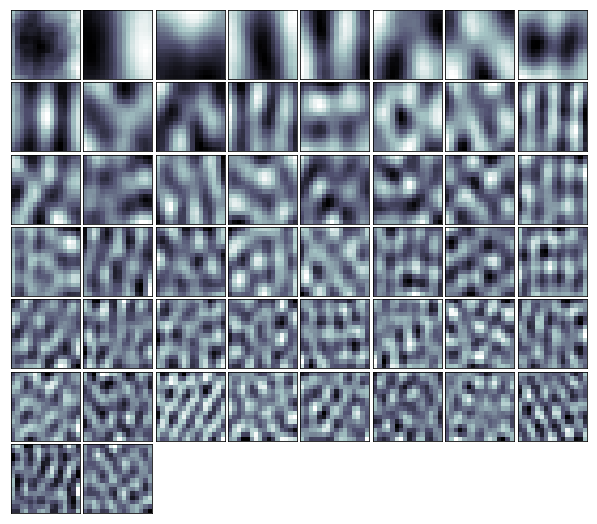

In [167]:
def runPCA(X):
    X = X.reshape(1000, 256)
    PCA_X = PCA(50)
    X_proj = PCA_X.fit_transform(X)
    
    #reconstruct error
    new_X = np.dot(X_proj,PCA_X.components_)
    #print(new_X.shape)
    error = 0
    for i in range(1000):
        error += np.linalg.norm((X[i]- new_X[i]),2)
    print("PCA learning error per input: ",error/1000)
    fig = plt.figure(figsize=(8,8)) 
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(50): 
        ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[]) 
        ax.imshow(np.reshape(PCA_X.components_[i,:], (16,16)), cmap=plt.cm.bone, interpolation='nearest')
    
runPCA(X)
    

In [170]:
def runOMP(X):
    X = X.reshape(1000, 256)
    x = MiniBatchDictionaryLearning(n_components = 350, transform_algorithm='omp', alpha=1, n_iter=500)
    y = x.fit(X)
    W = y.components_
    X_Proj = x.transform(X)
    new_X = np.dot(X_Proj,W)
    error = 0
    for i in range(1000):
        error += np.linalg.norm((X[i]- new_X[i]),2)
    print("DL error per input is: ",error/1000)
    return y.components_
    
W = runOMP(X)

DL error per input is:  90.44438227734753


In [172]:
def computeZU(U, Z, lamda):
    for i in range(0,1000):
        temp = 1/U[i]
        temp = temp/2
        U_Matrix = np.diag( temp ) 
        Z[i] = np.matmul( inv( WWT + lamda*U_Matrix ) , np.matmul(W, X[i].transpose()) )
        U[i] = np.absolute(Z[i])
    U[U<epsilon] = epsilon
    return Z, U

In [179]:
def computeError(lamda):
    #print(X.shape, W.shape, Z.shape, np.matmul(Z, W).shape, (X - np.matmul(Z, W)).shape)
    first = 0
    eachError = np.zeros(1000)
    for i in range(0, 1000):
        eachError[i] = np.dot(X[i] - np.matmul(Z[i], W), (X[i] - np.matmul(Z[i], W)).transpose())
        first += eachError[i]
    second = 0
    for i in range(0, 1000):
        for j in range(0, 350):
            second += abs(Z[i][j])
    #print("error: " , second, first)    
    return first + (lamda*second)

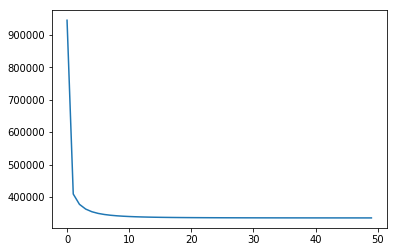

In [180]:
errors = []
lamda = 0.1
epsilon = 0.1
N_input = 10000
X = X.reshape(1000,256)
Z = np.zeros((1000, 350))
U = np.ones((1000, 350))

WWT = np.matmul(W, W.transpose())
Z = computeZ(U, Z, lamda)
Z, U = computeZU(U, Z, lamda)
def cycle(U, Z):
    for i in range(0, 50):
        error = computeError(lamda)
        errors.append(error)
        #print("**********", error)
        Z, U = computeZU(U, Z, lamda)
    plt.plot(errors)
    plt.show()
cycle(U, Z)

In [187]:
def runSpams(Z, X):
    param = { 'K' : 350, 
          'lambda1' : 0.15, 'numThreads' : 4,
          'iter' : 100}
    Y = np.asfortranarray(X)
    spams_Z = spams.trainDL(Y,**param)
    print("difference between generated Z and the spams outputted Z is: ", np.linalg.norm((Z - spams_Z),2))
runSpams(Z, X)

difference between generated Z and the spams outputted Z is:  26945.946085782925
